# Eval on a CNN

Up until now, we have always been running our `eval` query on basic ReluFNNs.
Another popular type of networks are convolutional neural networks, which are
especially effective in handling images. In this notebook, we'll show how we can
transform a convolutional layer to an extra hidden layer. This makes it possible
to run our `eval` query on it, without any alterations.

## The network

We'll use [PyTorch's MNIST
example](https://github.com/pytorch/examples/blob/main/mnist/main.py) as the CNN
of our choice. The following code is taken directly from the example, with a few
adaptations:

1. The PyTorch example is written to be a CLI app. We remove the CLI part and
   simply construct the network in code.
2. The example uses a `max_pool2d` layer. Our work currently does not support
   this, so we omit this layer. A pooling layer reduces the number of neurons,
   so we adjust the number of `conv2` output channels accordingly.

In [1]:
# https://github.com/pytorch/examples/blob/main/mnist/main.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import os
import networkx as nx
import utils.duckdb as db
import random
import matplotlib.pyplot as plt
import itertools
import pandas as pd


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        # We divide by 4 here to adjust for the removed max_pool2d layer.
        self.conv2 = nn.Conv2d(32, 64 // 4, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        # We removing the pooling layer since we can't implement it yet.
        # x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [2]:
# Takes 5-6mins on a decent machine.
def load_or_train_model():
    save_path = "models/mnist_cnn.pt"

    if os.path.exists(save_path):
        model = Net()
        model.load_state_dict(torch.load(save_path, weights_only=True))
        model.eval()

        return model

    # These are the default values for the CLI app.
    class args():
        epochs = 14
        torch.manual_seed(1)
        device = torch.device("cpu")
        batch_size = 64
        learning_rate = 1.0
        gamma = 0.7
        log_interval = 10
        dry_run = False

    args = args()

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    dataset1 = datasets.MNIST('../data', train=True, download=True,
                        transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                        transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset1, batch_size=args.batch_size)
    test_loader = torch.utils.data.DataLoader(dataset2, batch_size=args.batch_size)

    model = Net().to(args.device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.learning_rate)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, args.device, train_loader, optimizer, epoch)
        test(model, args.device, test_loader)
        scheduler.step()

    torch.save(model.state_dict(), save_path)

    return model

model = load_or_train_model()

With the model trained and ready, we'll go on and insert it in the database. The
difficult part is to translate the convolutions into a "regular" hidden layer.

Say we have a 3x3 kernel. In a convolution, this kernel is moved in a sliding
window over the input matrix. In each step, the input pixels are multiplied
element-wise with the kernel's corresponding weight value and then summed. We
can simulate this behavior by connecting each group of 9 input nodes to the
corresponding output node, and setting the kernel weights as the weight for each
edge. The summing is part of our regular model evaluation.

The following function is a utility function to find out which input points are
responsible for a given output point after the convolution.

In [3]:
def get_contributing_points(output_point, kernel_size, stride=1, padding=0):
    """
    Given an output point (of the image after convolution), calculates which
    points of the input image contributed. They are returned, along with the
    corresponding kernel location.
    """

    x_out, y_out = output_point
    x_in_start = x_out * stride - padding
    y_in_start = y_out * stride - padding

    contributing_points = []
    for i in range(kernel_size):
        for j in range(kernel_size):
            x_in = x_in_start + i
            y_in = y_in_start + j
            contributing_points.append(((x_in, y_in), (i, j)))

    return contributing_points

The following code constructs the network in the database. It is tedious to
translate the convolutions, because the model also uses multiple channels for
the convolutions.

In [4]:
def load_or_create_database(model):
    save_path = "dbs/eval_cnn.db"

    if os.path.exists(save_path):
        db.reconnect()
        db.con.execute(f"IMPORT DATABASE '{save_path}'")
        print(f"Importing existing database {save_path}")
        return

    db._initialize_database()

    # We have to hardcode this
    input_size = 28

    state_dict = model.state_dict()
    _, conv1_kernel_size, _ = state_dict['conv1.weight'][0].size()

    node_idx = 1
    nodes = {}

    conv1_weight = state_dict['conv1.weight']
    conv1_bias = state_dict['conv1.bias']
    conv1_output_size = input_size - conv1_kernel_size + 1

    conv1_out_channels, conv1_in_channels, conv1_kernel_size, _ = conv1_weight.size()
    if conv1_in_channels != 1:
        raise Exception("Not handling >1 input channels for now")

    conv2_weight = state_dict['conv2.weight']
    conv2_bias = state_dict['conv2.bias']

    conv2_out_channels, conv2_in_channels, conv2_kernel_size, _ = conv2_weight.size()
    conv2_output_size = conv1_output_size - conv2_kernel_size + 1

    fc1_weight = state_dict['fc1.weight']
    fc1_output_size, fc1_input_size = fc1_weight.size()

    fc2_weight = state_dict['fc2.weight']
    fc2_output_size, fc2_input_size = fc2_weight.size()

    def node_generator(nodes):
        node_idx = 1

        # Input nodes (1 channel for now)
        for y in range(0, input_size):
            for x in range(0, input_size):
                name = f"input.{x}.{y}"
                yield [node_idx, 0, name]
                nodes[name] = node_idx
                node_idx += 1

        # Conv1
        for y in range(0, conv1_output_size):
            for x in range(0, conv1_output_size):
                for c in range(0, conv1_out_channels):
                    name = f"conv1.{c}.{x}.{y}"
                    # The bias of this layer is simply the bias of the corresponding
                    # kernel
                    bias = conv1_bias[c]

                    yield [node_idx, bias.item(), name]
                    nodes[name] = node_idx
                    node_idx += 1

        # Conv2
        for y in range(0, conv2_output_size):
            for x in range(0, conv2_output_size):
                for c in range(0, conv2_out_channels):
                    name = f"conv2.{c}.{x}.{y}"
                    bias = conv2_bias[c]

                    yield [node_idx, bias.item(), name]
                    nodes[name] = node_idx
                    node_idx += 1

        # fc1
        for i in range(0, fc1_output_size):
            name = f"fc1.{i}"
            bias = state_dict['fc1.bias'][i]
            yield [node_idx, bias.item(), name]
            nodes[name] = node_idx
            node_idx += 1

        # fc2
        for i in range(0, fc2_output_size):
            name = f"fc2.{i}"
            bias = state_dict['fc2.bias'][i]
            yield [node_idx, bias.item(), name]
            nodes[name] = node_idx
            node_idx += 1

    def edge_generator(nodes):
        # Add the edges from input to conv1. Per channel, per output pixel of the
        # convolution, we have to match the 9 input pixels to it (for a 3x3 kernel)
        for c in range(0, conv1_out_channels):
            for y_conv in range(0, conv1_output_size):
                for x_conv in range(0, conv1_output_size):
                    # (x_conv, y_conv) is the position in the output channel. We can
                    # find the 9 matching input values from them.
                    for (p_in, p_kernel) in get_contributing_points((x_conv, y_conv), conv1_kernel_size):
                        (x_in, y_in) = p_in
                        (x_kernel, y_kernel) = p_kernel

                        # 0 corresponds to the input channel (which we only have one
                        # of).
                        kernel = conv1_weight[c][0]
                        weight = kernel[y_kernel][x_kernel]

                        src = nodes[f"input.{x_in}.{y_in}"]
                        dst = nodes[f"conv1.{c}.{x_conv}.{y_conv}"]

                        yield [src, dst, weight.item()]


        # Add the edges from conv1 to conv2. This is similar as connecting the input to
        # conv1, except that we have 2 input channels. Outputs are summed per output
        # channel.
        for c_out in range(0, conv2_out_channels):
            for y_conv2 in range(0, conv2_output_size):
                for x_conv2 in range(0, conv2_output_size):
                    for (p_in, p_kernel) in get_contributing_points((x_conv2, y_conv2), conv2_kernel_size):
                        (x_in, y_in) = p_in
                        (x_kernel, y_kernel) = p_kernel

                        for c_in in range(0, conv2_in_channels):
                            kernel = conv2_weight[c_out][c_in]
                            weight = kernel[y_kernel][x_kernel]

                            src = nodes[f"conv1.{c_in}.{x_in}.{y_in}"]
                            dst = nodes[f"conv2.{c_out}.{x_conv2}.{y_conv2}"]

                            yield [src, dst, weight.item()]

        # Connect conv2 to fc1.
        for c in range(0, conv2_out_channels):
            for y_conv in range(0, conv2_output_size):
                for x_conv in range(0, conv2_output_size):
                    for i in range(0, fc1_output_size):
                        # By adding the channel offset, we flatten.
                        channel_offset = c * conv2_output_size * conv2_output_size
                        weight = fc1_weight[i][y_conv * conv2_output_size + x_conv + channel_offset]

                        src = nodes[f"conv2.{c}.{x_conv}.{y_conv}"]
                        dst = nodes[f"fc1.{i}"]

                        yield [src, dst, weight.item()]

        # Connect fc1 to fc2.
        for i in range(0, fc2_input_size):
            for j in range(0, fc2_output_size):
                weight = fc2_weight[j][i]

                src = nodes[f"fc1.{i}"]
                dst = nodes[f"fc2.{j}"]

                yield [src, dst, weight.item()]

    db.batch_insert(node_generator(nodes), "node")
    db.batch_insert(edge_generator(nodes), "edge")

    db.con.execute(f"EXPORT DATABASE '{save_path}'")
    print(f"Exported to {save_path}")

load_or_create_database(model)

Importing existing database dbs/eval_cnn.db


With that in place, we can create a function that inserts a given input image in
the `input` table in the database. This table is used in the `eval` query to
fetch the input data.

In [5]:
def load_image_into_input_table(image):
    db.con.execute("TRUNCATE input")
    for i, pixel in enumerate(image.flatten()):
        db.con.execute("""
            INSERT INTO input (input_set_id, input_node_idx, input_value)
            VALUES (0, $input_node_idx, $input_value)
        """,
        {'input_node_idx': i + 1, 'input_value': pixel.item()})
    db.con.execute(f"EXPORT DATABASE 'dbs/eval_cnn_w_input.db'")

The `eval` query we use is the recursive eval query from an [earlier
notebook](./1.4%20Eval%20-%20recursive.ipynb) with a slight addition: after
calculating the output values, we also perform a log softmax in SQL:

```sql
WITH
-- Original eval query is ommitted for brevity.
max_value AS (
    SELECT
        input_set_id,
        MAX(value) AS max_val
    FROM t_out
    GROUP BY input_set_id
),
log_sum_exp AS (
    SELECT
        t.input_set_id,
        LOG(SUM(EXP(t.value - m.max_val))) AS log_sum_exp
    FROM t_out t
    JOIN max_value m ON t.input_set_id = m.input_set_id
    GROUP BY t.input_set_id
)
SELECT
    t.input_set_id,
    t.id,
    t.value - m.max_val - lse.log_sum_exp AS log_softmax
FROM t_out t
JOIN max_value m ON t.input_set_id = m.input_set_id
JOIN log_sum_exp lse ON t.input_set_id = lse.input_set_id
ORDER BY t.id;
```

The full query is available [here](./queries/eval_recursive_from_input_with_softmax.sql).

In [6]:
with open("queries/eval_recursive_from_input_with_softmax.sql", "r") as file:
    query = file.read()

Let's pick an image from the dataset.

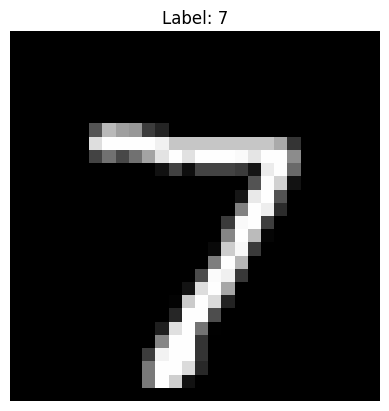

In [7]:
dataset = datasets.MNIST('../data', train=False)
image, label = dataset[0]
image = transforms.ToTensor()(image)
image_np = image.squeeze().numpy()

plt.imshow(image_np, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')  # Turn off axis
plt.show()

This is the model's result:

In [8]:
# Normalize it manually, cfr the transform of the dataset loader.
image = (image - 0.1307) / 0.3081

model(image.unsqueeze(0))

tensor([[-28.4653, -26.2044, -24.6023, -21.7036, -31.7144, -31.9441, -34.7408,
           0.0000, -30.6441, -21.9295]], grad_fn=<LogSoftmaxBackward0>)

And this is the result of our query:

In [9]:
load_image_into_input_table(image)
db.con.sql(query)

┌──────────────┬───────┬────────────────────────┐
│ input_set_id │  id   │      log_softmax       │
│    int32     │ int32 │         double         │
├──────────────┼───────┼────────────────────────┤
│            0 │ 31761 │     -28.46535068095316 │
│            0 │ 31762 │     -26.20436089898085 │
│            0 │ 31763 │     -24.60228292734754 │
│            0 │ 31764 │     -21.70356275675611 │
│            0 │ 31765 │    -31.714450652769717 │
│            0 │ 31766 │    -31.944062948848238 │
│            0 │ 31767 │     -34.74080294490496 │
│            0 │ 31768 │ -3.039444454216385e-10 │
│            0 │ 31769 │    -30.644082454459028 │
│            0 │ 31770 │     -21.92954830296085 │
├──────────────┴───────┴────────────────────────┤
│ 10 rows                             3 columns │
└───────────────────────────────────────────────┘

We can see that the results match: both the PyTorch model and the database
`eval` classify the image as a "7", with matching output weights.